Data Retrieved From: https://archive.ics.uci.edu/dataset/1/abalone

# Goal and Introduction

The goal is to use this dataset to predict the age of an abalone based on easier to measure criteria rather than rings (for which you have to cut into the specimen to count).

Most of the variables are already numerical, and the dataset is not missing values, according to the UCI website, so much of the annoying cleaning and encoding can be avoided. Based on the target data, it will be somewhat difficult to predict the age completely accurately. This is because there are many ages represented and the edges have very few data points. 

Random Forest might be the best for such a dataset but that's basically a guess.

## General Outline

* Ensure everything has the correct variable types, and look at the distribution of variables
* Apply Random Forest Classification to the data set
* Review the Results and attempt to optimize the model

In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn as sk

In [2]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
abalone = fetch_ucirepo(id=1) 
  
# data (as pandas dataframes) 
X = abalone.data.features 
y = abalone.data.targets 
  
# metadata 
print(abalone.metadata) 
  
# variable information 
print(abalone.variables) 


{'uci_id': 1, 'name': 'Abalone', 'repository_url': 'https://archive.ics.uci.edu/dataset/1/abalone', 'data_url': 'https://archive.ics.uci.edu/static/public/1/data.csv', 'abstract': 'Predict the age of abalone from physical measurements', 'area': 'Biology', 'tasks': ['Classification', 'Regression'], 'characteristics': ['Tabular'], 'num_instances': 4177, 'num_features': 8, 'feature_types': ['Categorical', 'Integer', 'Real'], 'demographics': [], 'target_col': ['Rings'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1994, 'last_updated': 'Mon Aug 28 2023', 'dataset_doi': '10.24432/C55C7W', 'creators': ['Warwick Nash', 'Tracy Sellers', 'Simon Talbot', 'Andrew Cawthorn', 'Wes Ford'], 'intro_paper': None, 'additional_info': {'summary': 'Predicting the age of abalone from physical measurements.  The age of abalone is determined by cutting the shell through the cone, staining it, and counting the number of rings through a microscope -- 

In [3]:
X.dtypes

Sex                object
Length            float64
Diameter          float64
Height            float64
Whole_weight      float64
Shucked_weight    float64
Viscera_weight    float64
Shell_weight      float64
dtype: object

In [4]:
pd.unique(X['Sex'])

array(['M', 'F', 'I'], dtype=object)

In [5]:
y.dtypes

Rings    int64
dtype: object

In [6]:
y.value_counts()

Rings
9        689
10       634
8        568
11       487
7        391
12       267
6        259
13       203
14       126
5        115
15       103
16        67
17        58
4         57
18        42
19        32
20        26
3         15
21        14
23         9
22         6
27         2
24         2
26         1
1          1
25         1
2          1
29         1
Name: count, dtype: int64

In [7]:
X.head()

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055


In [8]:
X.describe()

,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831
std,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500
25%,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,0.130000
50%,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000
75%,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000


<Axes: >

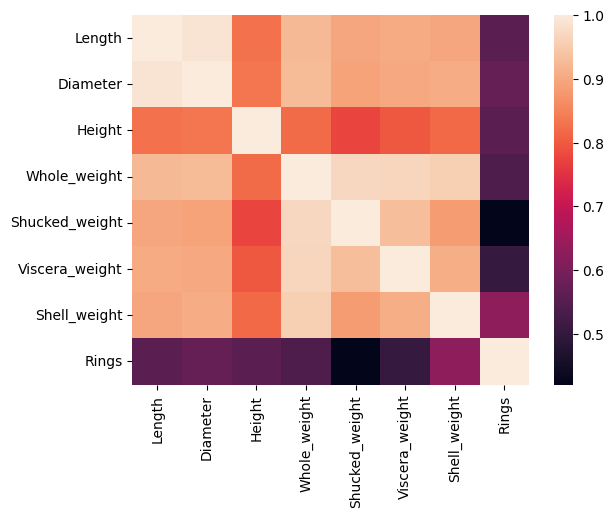

In [59]:
JointFrame = X.join(y)
sns.heatmap(JointFrame.corr(numeric_only=True))

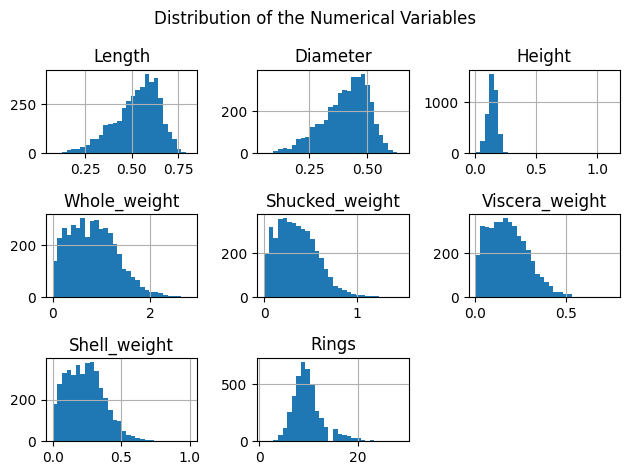

In [10]:
JointFrame.drop(['Sex'], axis=1).hist(bins=30)
plt.suptitle("Distribution of the Numerical Variables")
plt.tight_layout()

<Axes: >

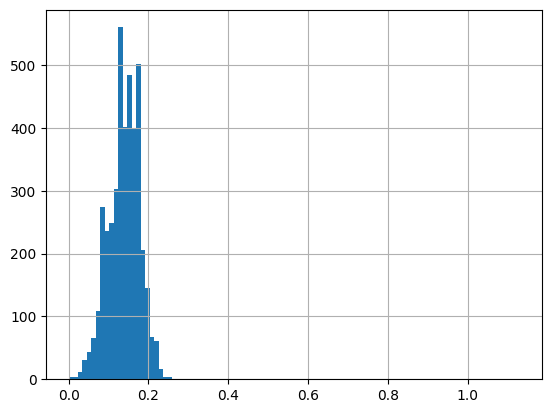

In [12]:
X['Height'].hist(bins=100)

In [21]:
X['Sex'].value_counts()

Sex
M    1528
I    1342
F    1307
Name: count, dtype: int64

In [51]:
JF_M = JointFrame[JointFrame['Sex'] == 'M'].reset_index().drop('index', axis=1)
JF_I = JointFrame[JointFrame['Sex'] == 'I'].reset_index().drop('index', axis=1)
JF_F = JointFrame[JointFrame['Sex'] == 'F'].reset_index().drop('index', axis=1)

In [52]:
JF_M.describe()

,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
count,1528.000000,1528.000000,1528.000000,1528.000000,1528.000000,1528.000000,1528.000000,1528.000000
mean,0.561391,0.439287,0.151381,0.991459,0.432946,0.215545,0.281969,10.705497
std,0.102697,0.084398,0.034804,0.470581,0.223000,0.104919,0.130834,3.026349
min,0.155000,0.110000,0.025000,0.015500,0.006500,0.003000,0.005000,3.000000
25%,0.505000,0.395000,0.130000,0.671625,0.276375,0.145875,0.190000,9.000000
50%,0.580000,0.455000,0.155000,0.975750,0.421750,0.210000,0.276000,10.000000
75%,0.630000,0.500000,0.175000,1.265625,0.566000,0.278000,0.355500,12.000000
max,0.780000,0.630000,0.515000,2.825500,1.351000,0.760000,0.897000,27.000000


In [53]:
JF_I.describe()

,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
count,1342.000000,1342.000000,1342.000000,1342.000000,1342.000000,1342.000000,1342.000000,1342.000000
mean,0.427746,0.326494,0.107996,0.431363,0.191035,0.092010,0.128182,7.890462
std,0.108858,0.088109,0.031995,0.286275,0.128405,0.062536,0.084927,2.511554
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,0.360000,0.270000,0.085000,0.205500,0.090000,0.042500,0.064125,6.000000
50%,0.435000,0.335000,0.110000,0.384000,0.169750,0.080500,0.113000,8.000000
75%,0.510000,0.390000,0.130000,0.599375,0.270375,0.130000,0.178500,9.000000
max,0.725000,0.550000,0.220000,2.049500,0.773500,0.440500,0.655000,21.000000


In [54]:
JF_F.describe()

,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
count,1307.000000,1307.000000,1307.000000,1307.000000,1307.000000,1307.000000,1307.000000,1307.000000
mean,0.579093,0.454732,0.158011,1.046532,0.446188,0.230689,0.302010,11.129304
std,0.086160,0.070954,0.039984,0.430316,0.198663,0.097617,0.125649,3.104256
min,0.275000,0.195000,0.015000,0.080000,0.031000,0.021000,0.025000,5.000000
25%,0.525000,0.410000,0.140000,0.730000,0.295000,0.159000,0.213250,9.000000
50%,0.590000,0.465000,0.160000,1.038500,0.440500,0.224000,0.295000,10.000000
75%,0.640000,0.505000,0.175000,1.320250,0.573250,0.297250,0.375000,12.000000
max,0.815000,0.650000,1.130000,2.657000,1.488000,0.590000,1.005000,29.000000


Text(0.5, 1.0, 'Number of Rings, Organized by Sex')

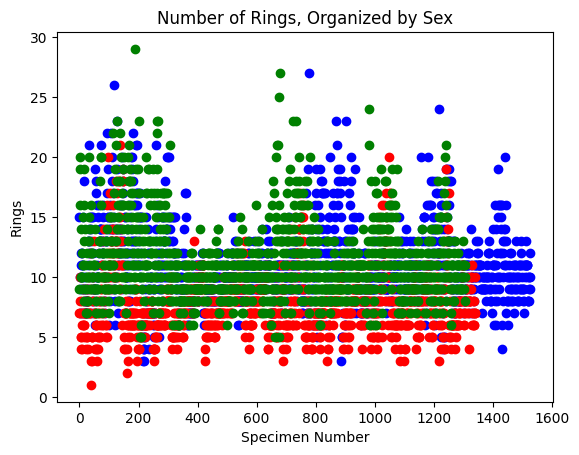

In [50]:
plt.scatter(JF_M.index, JF_M['Rings'], c='b')
plt.scatter(JF_I.index, JF_I['Rings'], c='r')
plt.scatter(JF_F.index, JF_F['Rings'], c='g')
plt.ylabel("Rings")
plt.xlabel('Specimen Number')
plt.title("Number of Rings, Organized by Sex")

<Axes: >

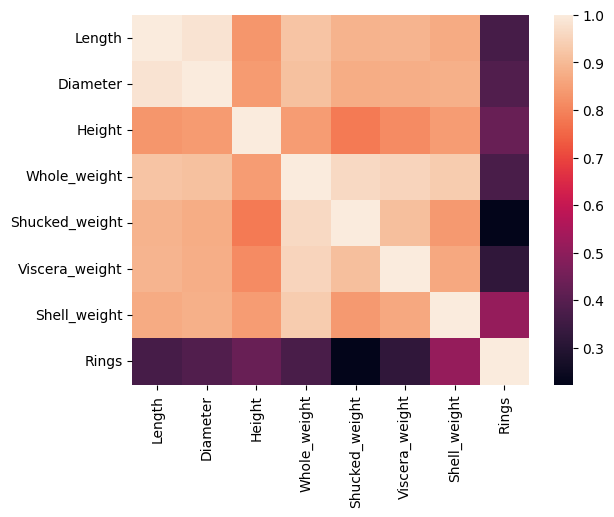

In [60]:
sns.heatmap(JF_M.drop('Sex', axis=1).corr())

<Axes: >

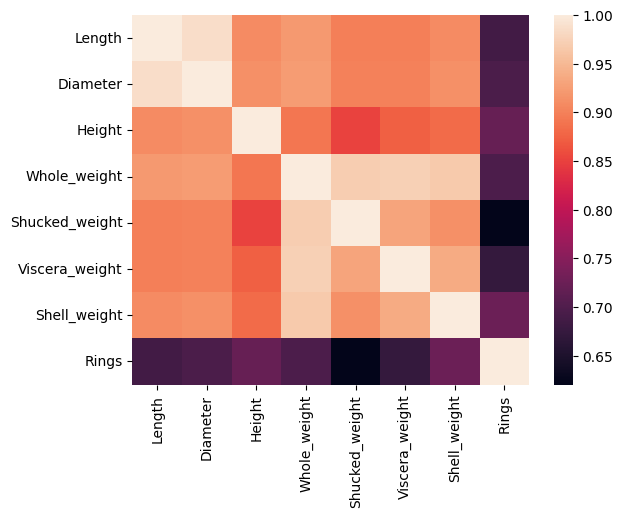

In [61]:
sns.heatmap(JF_I.drop('Sex', axis=1).corr())

<Axes: >

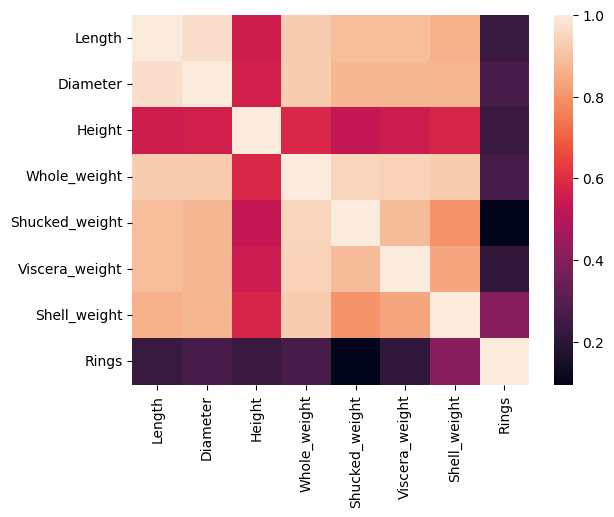

In [62]:
sns.heatmap(JF_F.drop('Sex', axis=1).corr())

array([[<Axes: title={'center': 'Rings'}>]], dtype=object)

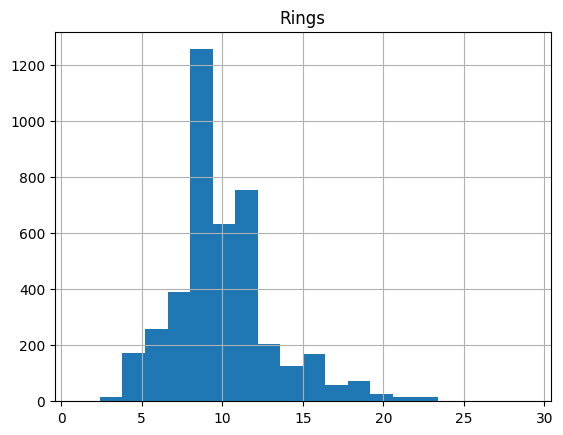

In [13]:
y.hist(bins=20)

In [14]:
X_encoded = pd.get_dummies(X, columns=["Sex"])
X_encoded.head()

,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Sex_F,Sex_I,Sex_M
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,False,False,True
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,False,False,True
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,True,False,False
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,False,False,True
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,False,True,False


Most of the data seems distributed somewhat normally, with there often being a left-sided bias, which is good. Outliers are not a significant worry, and with *Sex* encoded it should be easy to make the data work for most models. It's difficult to say which model will work well for the data, so a variety of linear models and Random Forest models will be tested and the top 3 or so will be picked and anlayzed further.

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_encoded,y)

In [16]:
from sklearn.linear_model import Ridge, LinearRegression, Lasso, ElasticNet
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import mean_squared_error, confusion_matrix, r2_score

In [17]:
models = [
    ('LR', LinearRegression()),
    ('Ridge', Ridge()),
    ('Lasso', Lasso()),
    ('EN', ElasticNet()),
    ('RFC', RandomForestClassifier()),
    ('RFR', RandomForestRegressor())
]

for name, model in models:
    model.fit(X_train, y_train.values.ravel())
    y_pred = model.predict(X_test)
    print(" %s with MSE of %s and score of %s" % (name, mean_squared_error(y_test, np.round(y_pred)), r2_score(y_test, y_pred)))

 LR with MSE of 5.147368421052631 and score of 0.5056076555847233
 Ridge with MSE of 5.086124401913875 and score of 0.5067171644400548
 Lasso with MSE of 10.17511961722488 and score of -0.00040500358918649226
 EN with MSE of 9.734928229665071 and score of 0.08556177280523403
 RFC with MSE of 6.320574162679426 and score of 0.37880047059145405
 RFR with MSE of 4.610526315789474 and score of 0.5473057194303654


MSE of 5.147368421052631 and score of 0.5473057194303654


<Axes: >

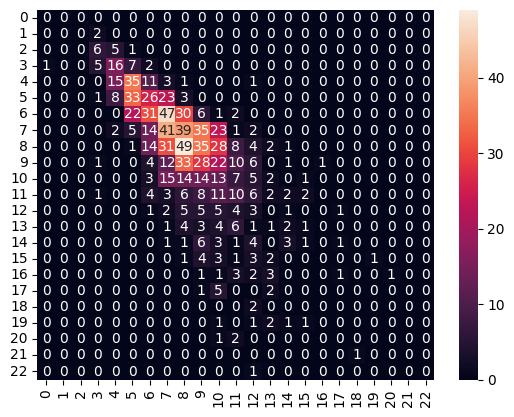

In [18]:
LR = LinearRegression()
LR.fit(X_train, y_train.values.ravel())
y_pred = LR.predict(X_test)
print("MSE of %s and score of %s" % (mean_squared_error(y_test, np.round(y_pred)), model.score(X_test, y_test)))
cm = confusion_matrix(y_test, np.round(y_pred))
sns.heatmap(cm, annot=True)

In [19]:
counter = 0
for i in range(len(cm)-1):
    counter+= cm[i][i]

counter / len(y_test)

0.22200956937799043

Now with a bit of forgiveness. Forgiveness means that for a true value of 5, a predicted value of 4,5, and 6 counts as a correct value.

In [20]:
counter = 0
for i in range(len(cm)-1):
    counter+= cm[i][i-1] + cm[i][i] + cm[i][i+1]

counter / len(y_test)

0.5866028708133971

Linear Regression, Ridge, and Random Forest Regressor give the best results, but they're still pretty bad. There will likely have to be significant optimization of hyperparameters for it to be acceptable. Though, there may be some way to optimize the test and train sets to better the chance of better results.

There is some improve that can be seen if you allow some margin of error. For example, with the above example the score rose significantly from a 21% accuracy to 59% accuracy. This is good but there are clear problems especially around 10 rings where the spread is much larger. The question is should this 